In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
# 定义黑体函数
def BlackBody(x, K=1e-2, kT=80.0):
    return K * x**2 / (np.exp(x/kT) - 1)

# 定义幂律函数
def Powerlaw(x, K=1.0, piv=1, index=.1):
    return K * (x/piv)**index

# 定义总函数
def f(x, K_bb=1e-2, kT=80.0, K_p=1.0, index=.1):
    return BlackBody(x, K_bb, kT) + Powerlaw(x, K_p, piv=1, index=index)

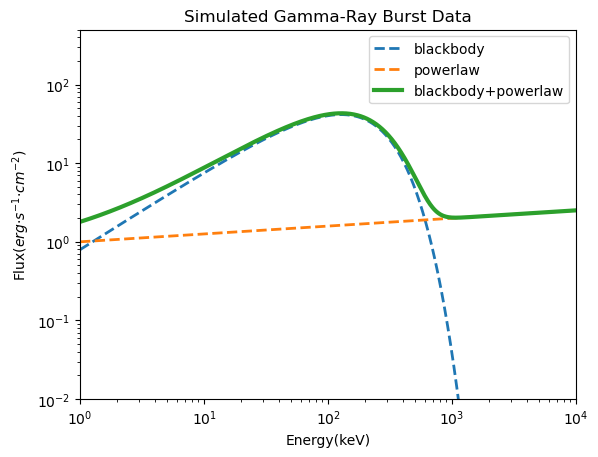

In [3]:
x = np.logspace(0, 4, 800) # 对应于范围1e0到2e4
fig,ax=plt.subplots()
ax.loglog(x,BlackBody(x, K=1e-2, kT=80.0),label='blackbody', linewidth=2, linestyle='dashed')
ax.loglog(x,Powerlaw(x, K=1.0, piv=1, index=.1),label='powerlaw', linewidth=2, linestyle='dashed')
ax.loglog(x,f(x, K_bb=1e-2, kT=80.0, K_p=1.0, index=.1),label='blackbody+powerlaw', linewidth=3)
ax.set_xlabel('Energy(keV)')
ax.set_ylabel('Flux($erg·s^{-1}·cm^{-2}$)')
ax.set_title('Simulated Gamma-Ray Burst Data')
ax.set_xlim([1e0, 1e4])
ax.set_ylim([1e-2, 5e2])
ax.legend()
fig.savefig('func.jpg',dpi=800)

In [4]:
# 生成数据
np.random.seed(123)  # 固定随机种子，保证结果可重现
x = np.logspace(0, 4, 100) # 对应于范围1e0到2e4
y_true = f(x)
y_obs = y_true + np.random.normal(loc=0, scale=2., size=y_true.size)

In [5]:
# 定义似然函数
def neg_log_likelihood(params):
    K_bb, kT, K_p, index = params
    y_model = f(x, K_bb, kT, K_p, index)
    return 0.5 * np.sum((y_obs - y_model)**2/2.**2)

In [6]:
# 拟合
initial_guess = [1e-2, 100.0, 2.0, 5.0]
result = minimize(neg_log_likelihood, initial_guess, method='Nelder-Mead')

In [7]:
# 输出拟合结果
print("拟合结果：", result.x)

拟合结果： [9.87356319e-03 8.16321133e+01 7.45787414e-01 1.21383447e-01]


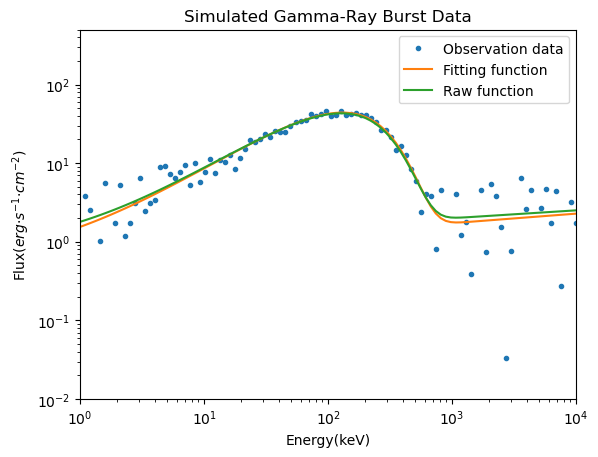

In [8]:
#绘图
fig,ax = plt.subplots()
ax.loglog(x, y_obs, '.', label='Observation data')
ax.loglog(x, f(x, *result.x), label='Fitting function')
ax.loglog(x,f(x, K_bb=1e-2, kT=80.0, K_p=1.0, index=.1),label='Raw function')
ax.set_xlabel('Energy(keV)')
ax.set_ylabel('Flux($erg·s^{-1}·cm^{-2}$)')
ax.set_title('Simulated Gamma-Ray Burst Data')
ax.set_xlim([1e0, 1e4])
ax.set_ylim([1e-2, 5e2])
ax.legend()
fig.savefig('compare.jpg',dpi=800)

### 对x轴的数据进行分区，然后在每个bin内对y轴的数据取平均，同时计算每个bin内数据的标准偏差作为误差条的长度。

/tmp/ipykernel_564/1679389534.py:24: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0, 2e4])


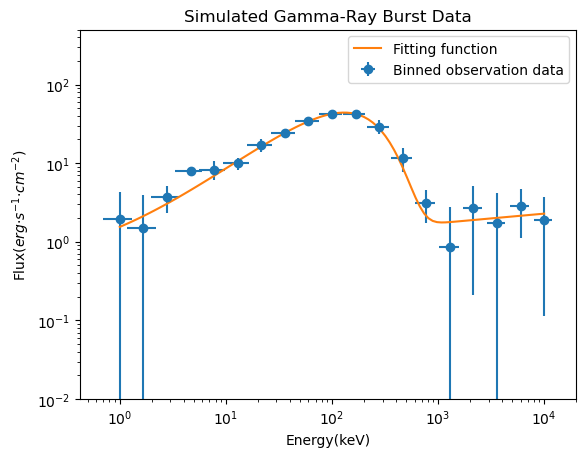

In [9]:
# 定义bins的边界
bins = np.logspace(0, 4., 20) # 这将创建19个bins

# 使用np.digitize计算每个x值属于哪个bin
indices = np.digitize(x, bins)

# 对每个bin进行迭代，计算y值的平均值和标准偏差
x_binned = np.logspace(0, 4., 19) # 新的x值为每个bin的中间点
y_binned = np.empty(19)
y_err = np.empty(19)
x_err = np.diff(bins) / 2 # 计算x轴的误差条长度，即每个bin的宽度的一半

for i in range(1, 20):
    y_binned[i-1] = np.mean(y_obs[indices == i])
    y_err[i-1] = np.std(y_obs[indices == i])

# 绘图
fig,ax = plt.subplots()
ax.errorbar(x_binned, y_binned, xerr=x_err, yerr=y_err, fmt='o', label='Binned observation data')
ax.loglog(x, f(x, *result.x), label='Fitting function')
ax.set_xlabel('Energy(keV)')
ax.set_ylabel('Flux($erg·s^{-1}·cm^{-2}$)')
ax.set_title('Simulated Gamma-Ray Burst Data')
ax.set_xlim([0, 2e4])
ax.set_ylim([1e-2, 5e2])
ax.legend()
fig.savefig('bin.jpg',dpi=800)

In [10]:
# 计算卡方值
def chi_square(params):
    K_bb, kT, K_p, index = params
    y_model = f(x, K_bb, kT, K_p, index)
    residuals = y_obs - y_model
    chi_sq = np.sum(residuals**2 / (0.5*y_model)**2)
    return chi_sq

# 使用最优参数计算卡方
chisq = chi_square(result.x)
print("卡方值：", chisq)


卡方值： 224.02618515376128
